# Whittle likelihood for 2-day signal

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import warnings
import multiprocessing
import os, datetime
from tqdm import tqdm

from lisatools.diagnostic import *
from lisatools.sensitivity import SensitivityMatrix, A1TDISens, E1TDISens, LISASens
from lisatools.utils.constants import *
from lisatools.detector import EqualArmlengthOrbits
from lisatools.datacontainer import DataResidualArray 
from lisatools.analysiscontainer import AnalysisContainer

from few.waveform import GenerateEMRIWaveform
from few.utils.constants import *
from few.trajectory.inspiral import EMRIInspiral

from fastlisaresponse import pyResponseTDI, ResponseWrapper

try:
    import cupy as cp
except Exception:
    cp = None

In [2]:
# gpu
use_gpu = False

Define FEW parameters

In [3]:
# metric
metric = "FastKerrEccentricEquatorialFlux"   # Kerr
traj = "KerrEccEqFlux"

In [4]:
# Observation parameters
#Tobs = 1  # [years]
#dt = 50.0  # [s]

Tobs = 0.006 # almost 2 days [yrs]
dt = 10.0  # [s]
eps = 1e-5  # mode content

emri_waveform_kwargs = dict(T=Tobs, dt=dt, eps=eps)

In [5]:
# Waveform parameters
M = 1e6  # central object mass
mu = 10  # secondary object mass
a = 0.5  # spin (will be ignored in Schwarzschild waveform)
#p0 = 8.2  # initial semi-latus rectum
p0 = 5.2  # initial semi-latus rectum
e0 = 0.5  # eccentricity
x0 = 1.0  # cosine of inclination 
dist = 1.0  # distance

qK = np.pi / 6  # polar spin angle (theta)
phiK = np.pi / 3  # azimuthal viewing angle
qS = np.pi / 6  # polar sky angle
phiS = np.pi / 3  # azimuthal viewing angle

Phi_phi0 = np.pi / 3
Phi_theta0 = np.pi / 6
Phi_r0 = np.pi / 3



emri_waveform_args = [
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
]

Define detector response parameters

In [6]:
# TDI

tdi_chan="AE"
tdi_labels=["A", "E"]

#tdi_chan="AET"
#tdi_labels=["A", "E", "T"]

order = 25 # order of the langrangian interpolation (for strain and orbits?)

tdi_gen="1st generation"
#tdi_gen="2nd generation"


response_kwargs = dict(
        Tobs=Tobs,
        dt=dt,
        #t0 = 100000.0,  # time at which signal starts (chops off data at start and end of waveform)
        order = order, # order of the langrangian interpolation (for strain and orbits?)
        index_beta = 7,   # Sky location parameters: theta --> qS
        index_lambda = 8, #                          phi --> phiS
        tdi=tdi_gen, 
        tdi_chan=tdi_chan,
        orbits=EqualArmlengthOrbits(),
    )

Generate TD data with detector response --> chans

In [7]:
# Initialise generator
td_gen = GenerateEMRIWaveform(
        metric,
        sum_kwargs=dict(pad_output=True, odd_len=True),
        return_list=False,
        use_gpu=use_gpu,
    )



lisa_response = ResponseWrapper(waveform_gen=td_gen,
                                flip_hx=True,
                                use_gpu=use_gpu,
                                remove_sky_coords=False,
                                is_ecliptic_latitude=False,
                                remove_garbage=False,
                                **response_kwargs)




def fastlisaresponse(*params, emri_waveform_kwargs=None):
    return lisa_response(*params, **(emri_waveform_kwargs or {}))

In [8]:
# Generate a waveform
start = time.time()
chans = fastlisaresponse(
    *emri_waveform_args,
    emri_waveform_kwargs=emri_waveform_kwargs,
)
print(f"Waveform generation took {time.time()-start:.2f} s")

Waveform generation took 10.74 s


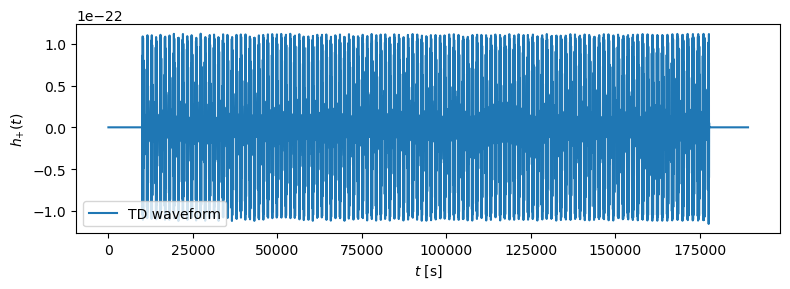

In [9]:
# Visualise the signal
time_array = np.arange(0,len(chans[0]))*dt

plt.figure(figsize=(8,3))
plt.plot(time_array, chans[0], label='TD waveform')
plt.ylabel(r'$h_{+}(t)$')
plt.xlabel(r'$t$ [s]')
#plt.xlim(2.3e7,2.7e7)
plt.legend()
plt.tight_layout()

plt.show()

Transform in FD and cut the data above minimum frequency

In [10]:
# Compute f_min
r_apo = p0 * M * MTSUN_SI / (1 - e0)  # meters
r_per = p0 * M * MTSUN_SI / (1 + e0)  # meters
r0 = (r_apo+r_per)/2

f_orb_0 = np.sqrt(M * MTSUN_SI / r0**3) / (2 * np.pi)  # rad/s

f_min = 2 * f_orb_0

In [11]:
N = len(chans[0])
freqs = np.fft.rfftfreq(N, d=dt)       
complete_data = np.fft.rfft(chans, axis=-1) * dt 

freq_threshold = f_min
mask = freqs > freq_threshold

data_filtered = complete_data[:,mask]
freq_filtered = freqs[mask]

Define positive psd matrix

In [12]:
pos_psd = np.vstack([
    get_sensitivity(freq_filtered, sens_fn="A1TDISens"),
    get_sensitivity(freq_filtered, sens_fn="E1TDISens"),
])

### Direct implementation

Inner product function

In [13]:
def inner_product(a, b, freqs, pos_psd, return_complex=False):
    """
    Noise-weighted inner product of two frequency-domain signals.
    
        (a|b) = 4 Re ∫_{f>0} a(f) b*(f) / S_n(f) df

    Args:
    a, b : shape (nf,) or (nchannels, nf) --> Complex frequency-domain signals.
    freqs : shape (nf,)                   --> Frequency values corresponding to the signal samples.
    pos_psd : shape (nf,) or (nchannels, nf) --> One-sided power spectral density S_n(f).
    return_complex : bool, default False  --> If True, return the full complex inner product before taking the real part.

    Returns:
    float, complex, or array --> The inner product (summed over channels). Real scalar by default.
    """

    xp = cp if (cp is not None and any(isinstance(x, cp.ndarray) for x in (a, b, freqs, pos_psd))) else np
    
    a, b, freqs, pos_psd = (xp.asarray(x) for x in (a, b, freqs, pos_psd))
    
    if a.ndim == 1: a = a[None, :]
    if b.ndim == 1: b = b[None, :]
    if a.shape != b.shape: raise ValueError("a and b must match")

    nch, nf = a.shape

    pos_psd = pos_psd if pos_psd.ndim==2 else pos_psd[None, :]

    start = 1 if xp.isnan(pos_psd[...,0]).any() else 0
    
    integrand = a[:, start:] * b[:, start:].conj() / pos_psd[:, start:]
    val = 4.0 * xp.trapezoid(integrand, x=freqs[start:], axis=1).sum()
    
    if not return_complex: val = xp.real(val)
        
    return val.item() if xp is np else val

Signal generator function (it contains also the cut)

In [14]:
def signal_gen(*emri_waveform_args):
    chans = fastlisaresponse(*emri_waveform_args, emri_waveform_kwargs=emri_waveform_kwargs)

    nchan, N = np.shape(chans)
    freqs = np.fft.rfftfreq(N, d=dt)       
    complete_data = np.fft.rfft(chans, axis=-1) * dt 

    freq_threshold = f_min
    mask = freqs > freq_threshold

    data_filtered = complete_data[:,mask]
    freq_filtered = freqs[mask]

    return data_filtered

Function for the log likelihood computed following the Whittle likelihood formula presented
in O.Burke+(2025).

I call this 'direct' implementation because it doesn't use any lisatools function.

In [15]:
def log_likelihood(d, *emri_waveform_args, freqs=freq_filtered, pos_psd=pos_psd, **inner_kwargs):
    """
    Compute the Whittle log-likelihood
        ln L = -1/2 * (h(theta) - d | h(theta) - d)
    where `h` is produced by `signal_gen(*emri_waveform_args)`.

    Args:
        d: Observed data. Must be compatible with the input format of `inner_product`
        *emri_waveform_args: Arguments passed directly to `signal_gen` in order to 
            generate the waveform model `h(theta)`.
        freqs: Frequency array corresponding to the domain of the data and waveform.
            Default is `freq_filtered`.
        psd: One- or multi-channel Power Spectral Density used for weighting the inner 
            product. Default is `pos_psd`.
        **inner_kwargs: Additional arguments to `inner_product` (e.g. `complex`).

    Returns:
        float or complex: Value of the Whittle log-likelihood. Returns a real scalar by
            default, or complex if `complex=True` is passed in `inner_kwargs`.
    """
    
    h = signal_gen(*emri_waveform_args)

    r = h - d

    chi2 = inner_product(r, r, freqs=freqs, pos_psd=pos_psd, **inner_kwargs)

    return -0.5 * chi2

Function that computes the likelihood between TD domain data (chans) and a signal generated 
with given parameters (*emri_waveform_args)

In [16]:
def compute_direct_logL(chans, *emri_waveform_args):
    nchan, N = np.shape(chans)
    freqs = np.fft.rfftfreq(N, d=dt)       
    complete_data = np.fft.rfft(chans, axis=-1) * dt 
    
    freq_threshold = f_min
    mask = freqs > freq_threshold
    
    data_filtered = complete_data[:,mask]
    freq_filtered = freqs[mask]

    return log_likelihood(data_filtered, *emri_waveform_args)

### Lisatools implementation

Functions to compute the Whittle log likelihood using the lisatools implementation.

The likelihood is computed between TD domain data (chans) and a signal generated 
with given parameters (*emri_waveform_args)

In [17]:
def signal_gen_lisatools(*emri_waveform_args):
    complete_data = DataResidualArray(fastlisaresponse(*emri_waveform_args, emri_waveform_kwargs=emri_waveform_kwargs), dt=dt)

    freqs = complete_data.f_arr
    mask = freqs > freq_threshold

    return DataResidualArray(complete_data[:, mask], f_arr=freqs[mask])


def compute_lisatools_logL(chans, *emri_waveform_args):
    # Cut the data
    complete_data = DataResidualArray(chans, dt=dt)
    
    freq_threshold = f_min
    freqs = complete_data.f_arr
    mask = freqs > freq_threshold
    
    data_filtered = complete_data[:,mask]
    freq_filtered = freqs[mask]
    
    data = DataResidualArray(data_filtered, f_arr=freq_filtered)
    
    sens_mat = SensitivityMatrix(data.f_arr, [A1TDISens, E1TDISens])

    analysis = AnalysisContainer(data, sens_mat, signal_gen=signal_gen_lisatools)

    return analysis.calculate_signal_likelihood(*emri_waveform_args, source_only=True)

### Comparison

Compare likelihood implementations: direct vs. lisatools

1. Start from dataset `chans`
2. Define parameter set; vary primary mass over `M_grid`
3. For each mass:
     - generate corresponding signal
     - compute likelihood between data and signal
4. Repeat for both implementations to compare results 

In [18]:
M_grid = np.linspace(9e5, 1.1e6, 11)

In [19]:
direct_logL = -1 * np.ones(len(M_grid))
lisatools_logL = -1 * np.ones(len(M_grid))

# Generate a waveform
start = time.time()
chans = fastlisaresponse(
    *emri_waveform_args,
    emri_waveform_kwargs=emri_waveform_kwargs,
)

for idx, M in tqdm(enumerate(M_grid), total=len(M_grid), desc='M grid'):
    emri_waveform_args_M = [
        M,
        mu,
        a,
        p0,
        e0,
        x0,
        dist,
        qS,
        phiS,
        qK,
        phiK,
        Phi_phi0,
        Phi_theta0,
        Phi_r0,
    ]

    
    direct_logL[idx] = compute_direct_logL(chans, *emri_waveform_args_M)
    lisatools_logL[idx] = compute_lisatools_logL(chans, *emri_waveform_args_M)

M grid: 100%|█████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:06<00:00,  1.76it/s]


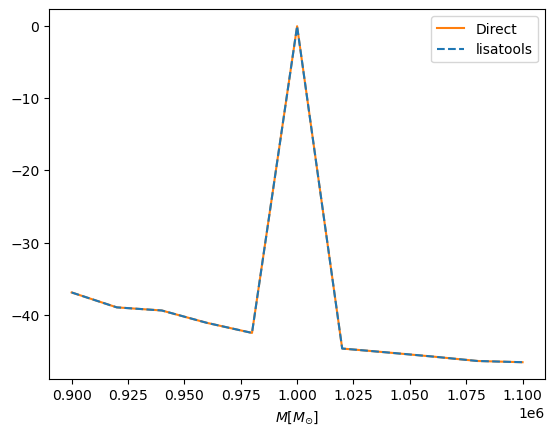

In [20]:
plt.plot(M_grid, direct_logL, color='C1', label='Direct')
plt.plot(M_grid, lisatools_logL, linestyle='--', color='C0', label='lisatools')

plt.xlabel(r'$M [M_{\odot}]$')
plt.legend()
plt.show()

The likelihood goes to zero when M is the same used for generating the dataset, as expected.

Vary mu

In [22]:
mu_grid = np.linspace(9.9, 10.1, 11)

direct_logL = -1 * np.ones(len(mu_grid))

# Generate a waveform
start = time.time()
chans = fastlisaresponse(
    *emri_waveform_args,
    emri_waveform_kwargs=emri_waveform_kwargs,
)
M=1e6
for idx, mu in tqdm(enumerate(mu_grid), total=len(mu_grid), desc='M grid'):
    emri_waveform_args_M = [
        M,
        mu,
        a,
        p0,
        e0,
        x0,
        dist,
        qS,
        phiS,
        qK,
        phiK,
        Phi_phi0,
        Phi_theta0,
        Phi_r0,
    ]

    
    direct_logL[idx] = compute_direct_logL(chans, *emri_waveform_args_M)


M grid: 100%|█████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.84it/s]


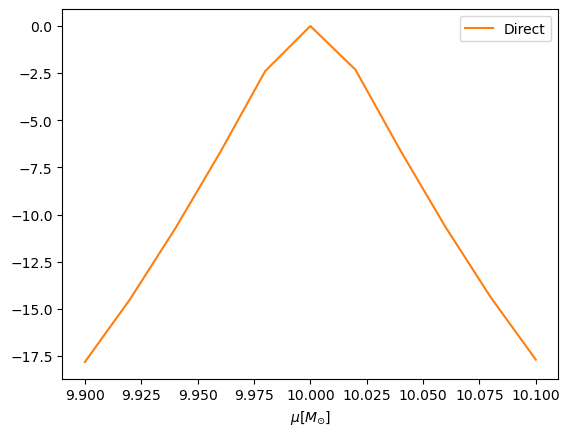

In [23]:
plt.plot(mu_grid, direct_logL, color='C1', label='Direct')

plt.xlabel(r'$\mu [M_{\odot}]$')
plt.legend()
plt.show()